Data sample with Return:


,date,price,ticker,Return
0,2025-02-24,98.742737,STX,-0.007635
1,2025-02-25,98.387543,STX,-0.003597
2,2025-02-26,98.930191,STX,0.005515
3,2025-02-27,99.324852,STX,0.003989
4,2025-02-28,100.548286,STX,0.012318


Fraction flagged as outliers (IQR): 0.08064516129032258
Fraction flagged as outliers (Z-score): 0.024193548387096774


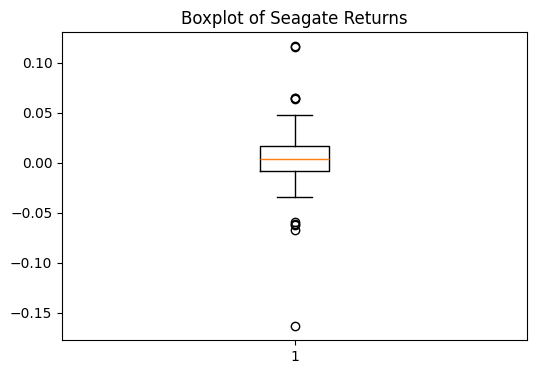

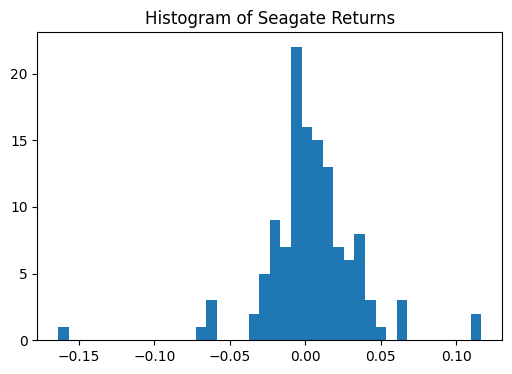

Summary comparison:


,all,filtered_iqr,winsorized
mean,0.004246,0.004520,0.004617
median,0.003318,0.003318,0.003318
std,0.031216,0.018298,0.020256


Processed file saved to C:\Users\10341\bootcamp_Jiayuan_zhang\project\data\processed\seagate_no_outliers.csv


In [ ]:

import os, sys
from pathlib import Path

PROJECT_ROOT = Path("..").resolve()
SRC_DIR = PROJECT_ROOT / "src"


if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

SRC_DIR.mkdir(exist_ok=True, parents=True)
init_file = SRC_DIR / "__init__.py"
if not init_file.exists():
    init_file.write_text("")  


import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display


from src.features import add_returns
from src.outliers import detect_outliers_iqr, detect_outliers_zscore, winsorize_series


raw_dir = PROJECT_ROOT / "data" / "raw"
processed_dir = PROJECT_ROOT / "data" / "processed"
os.makedirs(processed_dir, exist_ok=True)


csv_path = raw_dir / "STX_prices_20250820-234954.csv"  
df = pd.read_csv(csv_path, parse_dates=["date"])


df = add_returns(df, price_col="price").dropna().reset_index(drop=True)

print("Data sample with Return:")
display(df.head())


df["outlier_iqr"] = detect_outliers_iqr(df["Return"])
df["outlier_z"] = detect_outliers_zscore(df["Return"], threshold=3.0)

print("Fraction flagged as outliers (IQR):", df["outlier_iqr"].mean())
print("Fraction flagged as outliers (Z-score):", df["outlier_z"].mean())



plt.figure(figsize=(6,4))
plt.boxplot(df["Return"], vert=True)
plt.title("Boxplot of Seagate Returns")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(df["Return"], bins=40)
plt.title("Histogram of Seagate Returns")
plt.show()



summ_all = df["Return"].describe()[["mean", "50%", "std"]].rename({"50%": "median"})
summ_filtered = df.loc[~df["outlier_iqr"], "Return"].describe()[["mean", "50%", "std"]].rename({"50%": "median"})
w = winsorize_series(df["Return"])
summ_w = w.describe()[["mean", "50%", "std"]].rename({"50%": "median"})

comp = pd.concat(
    {"all": summ_all, "filtered_iqr": summ_filtered, "winsorized": summ_w},
    axis=1
)

print("Summary comparison:")
display(comp)



df_filtered = df.loc[~df["outlier_iqr"]].copy()
out_path = processed_dir / "seagate_no_outliers.csv"
df_filtered.to_csv(out_path, index=False)
print(f"Processed file saved to {out_path}")
